# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

**Наша задача**

Нам нужно построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. Метрика MAE на тестовых данных должна составить не больше 8.

**Описание данных**

В вашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

Целевой признак - real_age - возраст.

**План работы будет таким:**

1. Загрузка и исследовательский анализ данных.
2. Подготовка данных к обучению.
3. Обучение нейронной сети с расчётом её качества.
4. Анализ обученной модели.
5. Выводы.

Прежде чем загружать датасеты, нужно провести импорт необходимых библиотек.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

Кроме того, напишем функцию, которая пригодится нам в дальнейшей работе.

In [ ]:
# Функция получения общей информации о датасете, о дубликатах и пропусках.
def information(df):
    df.info();
    print('\nКоличество дубликатов:',df.duplicated().sum(),'\n')
    print('Количество пропусков:\n',df.isna().sum())


Функции для подготовки данных к обучению нейронной сетью отразим ниже, в соответствующем разделе.

## Исследовательский анализ данных

Загрузим датасеты, используя ImageDataGenerator для загрузки картинок.

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


После загрузки картинок мы уже можем посмотреть их количество - 7591.

Посмотрим общую информацию о датасете с целевым признаком.

In [ ]:
information(labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB

Количество дубликатов: 0 

Количество пропусков:
 file_name    0
real_age     0
dtype: int64


Видим, что в нем 7591 строка, пропусков и дубликатов нет. То есть количество строк с целевым признаком совпадает с числом картинок. Теперь посмотрим распределение возраста в нашем датасете.

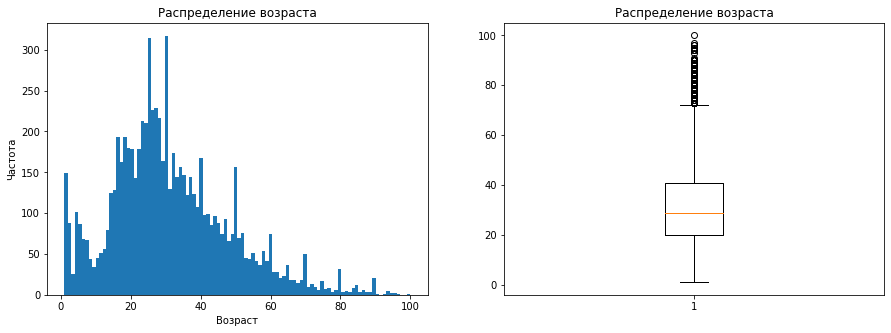

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(labels['real_age'], bins=100);
ax1.set_title('Распределение возраста')
ax1.set_xlabel('Возраст')
ax1.set_ylabel('Частота')
ax2.boxplot(labels['real_age']);
ax2.set_title('Распределение возраста')
plt.show()

Распределение выглядит почти нормальным, преобладают люди с возрастом в районе 20-40 лет с пиками примерно в 25 и в 30 лет. Кроме того есть пики в каждые 10 лет, вероятно это связано с примерностью возраста некоторых лиц (возможно не все хотели называть свой точный возраст). Есть и изображения детей (причем довольно много от 0 до 7-8 лет) и пожилых людей. Все, кто старше, 70 попали в выбросы.

Теперь посмотрим, что представляет из себя датасет с картинками.

In [ ]:
features, target = next(gen_flow)

print(features.shape)

(32, 224, 224, 3)


Объекты в датасете представляют собой четырёхмерный тензор, в котором 32 изображения размером 224x224 с тремя цветовыми каналами. Теперь вывыдем на экран несколько фотографий, чтобы посмотреть, как они выглядят.

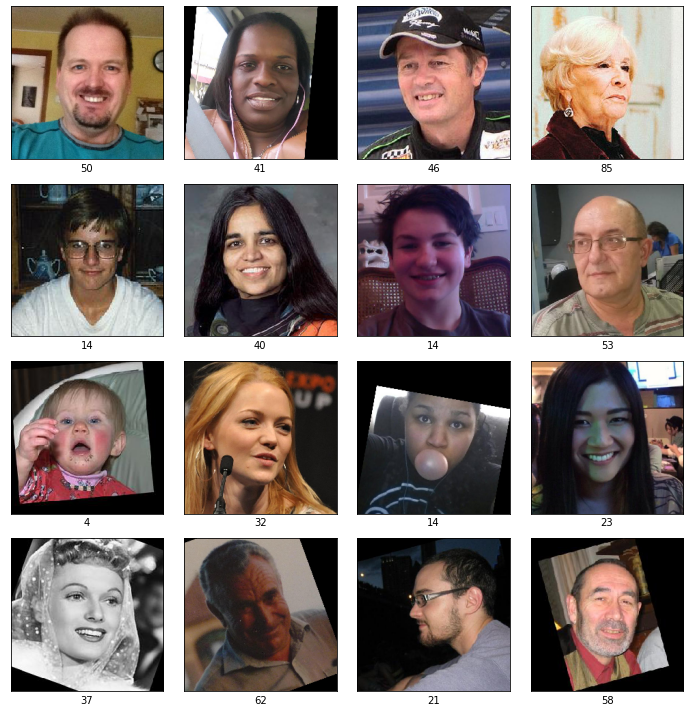

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На фотографиях лица людей, лица распологаются по центру картинки, в основном в профиль.

***Выводы:*** Мы загрузили данные и провели исследовательский анализ. Выяснили, что имеется 7591 файл с фотографиями, которым соответствуют 7591 метка с возрастом. Посмотрели распределение возрастов в датасете, оно похоже на нормальное, преобладают люди с возрастом в районе 20-40 лет с пиками примерно в 25 и в 30 лет. Кроме того есть пики в каждые 10 лет, вероятно это связано с примерностью возраста некоторых лиц (возможно не все хотели называть свой точный возраст). Есть и изображения детей (причем довольно много от 0 до 7-8 лет) и пожилых людей. Посмотрели, как выглядят фотографии и что из себя представляет датасет с фотографиями. Изучив эти данные, можно сделать вывод, что модель должна справиться с обучением (все фото одного формата с лицом по центру, качество изображений примерно одинаковое, распределение возрастов равномерное, количество изображений достаточно большое).

## Подготовка данных к обучению

Разделим выборку на тренировочную и тестовую выборки. Для этого напишем функции для их раздельной загрузки с помощью ImageDataGenerator.

In [ ]:
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,
    horizontal_flip=True)
    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_data

In [ ]:
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_data

Теперь напишем функцию для создания модели. В качестве нейронной сети будем использовать ResNet50. Так как определять наша модель должна возраст (то есть это задача регрессии), то последним слоем нейронной сети будет один нейрон с активацией Relu, в качестве функции потерь будем использовать MSE, а в качестве метрики MAE. В качестве оптимизатора используем алгоритм Adam со скоростью обучения 0.0001.

In [ ]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/???/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

***Выводы:*** Мы написали функции для подготовки данных к обучению (разделили датасеты на тренировочную и тестовую выборки), создали модель для нейронной сети ResNet50.

## Обучение модели

Напишем функцию для обучения модели. Зададим количество эпох, равное 3.

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=3,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

In [ ]:
train_model (create_model((224,224,3)), load_train(???), load_test(???), batch_size=None, epochs=3,
               steps_per_epoch=None, validation_steps=None)

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/3
2024-04-11 12:51:56.090679: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-11 12:51:56.566214: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 64s - loss: 198.7129 - mae: 10.3130 - val_loss: 645.1865 - val_mae: 20.4005
Epoch 2/3
356/356 - 45s - loss: 65.5827 - mae: 6.2063 - val_loss: 129.9056 - val_mae: 8.7161
Epoch 3/3
356/356 - 48s - loss: 38.9824 - mae: 4.8254 - val_loss: 79.3383 - val_mae: 6.7701
119/119 - 11s - loss: 79.3383 - mae: 6.7701
Test MAE: 6.7701

```

***Выводы:*** Мы написали функцию для обучения модели, провели ее обучение и получили результат метрики MAE на тестовой выборке 6.77, что соответствует критериям заказчика. Значит модель справилась с поставленной задачей.

## Анализ обученной модели

1. Для обучения мы использовали модель с архитектурой ResNet50, у которой убрали голову, заменив ее на полносвязный слой с одним нейроном, так как у нас стояла задача регрессии. Веса использовали предобученные, чтобы улучшить результат.

2. Параметры обучения: размер батча не задавался, в качестве оптимизатора использовали алгоритм Adam со скоростью обучения 0.0001, заморозку бэкбона не использовали, так как размер датасета достаточно большой, использовали три эпохи.

3. Метрика MAE на тестовых данных достигла 6.77, переобучения не наблюдалось, так как метрика последовательно снижалась от эпохи к эпохе и не превышает данные на обучающей выборке. Возможно добавление эпох привело бы к более лучшим результатам, для этого можно провести дополнительное исследование.

## Выводы

Мы провели работу по обучению модели, которая по фотографии определяет приблизительный возраст человека.
На пути к выполнению этой цели мы провели следующую работу:

1. Загрузили данные и провели исследовательский анализ. Выяснили, что имеется 7591 файл с фотографиями, которым соответствуют 7591 метка с возрастом. Посмотрели распределение возрастов в датасете, оно похоже на нормальное, преобладают люди с возрастом в районе 20-40 лет с пиками примерно в 25 и в 30 лет. Кроме того есть пики в каждые 10 лет, вероятно это связано с примерностью возраста некоторых лиц (возможно не все хотели называть свой точный возраст). Есть и изображения детей (причем довольно много от 0 до 7-8 лет) и пожилых людей. Посмотрели, как выглядят фотографии и что из себя представляет датасет с фотографиями. Изучив эти данные, сделили вывод, что модель должна справиться с обучением (все фото одного формата с лицом по центру, качество изображений примерно одинаковое, распределение возрастов равномерное, количество изображений достаточно большое).

2. Написали функции для подготовки данных к обучению (разделили датасеты на тренировочную и тестовую выборки), создали модель для нейронной сети ResNet50.

3. Написали функцию для обучения модели, провели ее обучение и получили результат метрики MAE на тестовой выборке 6.77, что соответствует критериям заказчика. Значит модель справилась с поставленной задачей.

4. Провели анализ обученной модели.

Мы убедились, что архитектура ResNet может справиться с любой задачей компьютерного зрения.